## 1. Importação de Bibliotecas

In [19]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento dos Dados

In [20]:
# Carregar dados de projetos
projetos_df = pd.read_csv('projetos.csv', delimiter=';')
print("Dados de Projetos:")
print(projetos_df.head(10))
print(f"\nTotal de projetos: {len(projetos_df)}")
print(f"Total de vagas disponíveis: {projetos_df['Numero_Vagas'].sum()}")

Dados de Projetos:
  Codigo_Projeto  Numero_Vagas  Requisito_Minimo_Nota
0             P1             2                      5
1             P2             1                      5
2             P3             2                      4
3             P4             1                      5
4             P5             2                      4
5             P6             2                      5
6             P7             2                      5
7             P8             2                      5
8             P9             2                      4
9            P10             3                      4

Total de projetos: 50
Total de vagas disponíveis: 80


In [21]:
# Carregar dados de alunos
alunos_df = pd.read_csv('alunos.csv', delimiter=';')
print("Dados de Alunos:")
print(alunos_df.head(10))
print(f"\nTotal de alunos: {len(alunos_df)}")
print(f"\nDistribuição de notas:")
print(alunos_df['Nota'].value_counts().sort_index())

Dados de Alunos:
  Codigo_Aluno Projeto_Preferencia_1 Projeto_Preferencia_2  \
0           A1                    P1                   P30   
1           A2                    P1                   P30   
2            A                    P0                    P4   
3            A                    P2                    P3   
4           A5                    P4                   P28   
5           A6                    P0                    P9   
6           A7                    P1                   P31   
7           A8                    P6                   P27   
8           A9                    P7                   P29   
9          A10                    P8                    P3   

  Projeto_Preferencia_3  Nota  
0                    P0     5  
1                    P1     5  
2                    P5     3  
3                    P5     4  
4                    P4     3  
5                   P10     4  
6                   P38     4  
7                    P8     5  
8           

## 3. Estruturas de Dados para o Algoritmo

In [22]:
class Projeto:
    def __init__(self, codigo, numero_vagas, requisito_minimo):
        self.codigo = codigo
        self.numero_vagas = numero_vagas
        self.requisito_minimo = requisito_minimo
        self.alunos_aceitos = []
        self.propostas_recebidas = []
        
    def pode_aceitar_aluno(self, aluno):
        return aluno.nota >= self.requisito_minimo
    
    def tem_vaga_disponivel(self):
        return len(self.alunos_aceitos) < self.numero_vagas
    
    def adicionar_aluno(self, aluno):
        if self.pode_aceitar_aluno(aluno):
            self.alunos_aceitos.append(aluno)
            return True
        return False
    
    def remover_pior_aluno(self):
        if self.alunos_aceitos:
            # Remove aluno com menor nota
            pior_aluno = min(self.alunos_aceitos, key=lambda a: a.nota)
            self.alunos_aceitos.remove(pior_aluno)
            return pior_aluno
        return None

class Aluno:
    def __init__(self, codigo, preferencias, nota):
        self.codigo = codigo
        self.preferencias = preferencias  # Lista ordenada de códigos de projetos
        self.nota = nota
        self.projeto_atual = None
        self.indice_proposta = 0  # Índice da próxima preferência a propor
        
    def proximo_projeto_preferido(self):
        if self.indice_proposta < len(self.preferencias):
            return self.preferencias[self.indice_proposta]
        return None
    
    def esta_emparelhado(self):
        return self.projeto_atual is not None

print("Classes Projeto e Aluno definidas!")

Classes Projeto e Aluno definidas!


## 4. Inicialização dos Objetos

In [23]:
# Criar dicionário de projetos
projetos = {}
for _, row in projetos_df.iterrows():
    codigo = row['Codigo_Projeto']
    projetos[codigo] = Projeto(
        codigo=codigo,
        numero_vagas=row['Numero_Vagas'],
        requisito_minimo=row['Requisito_Minimo_Nota']
    )

print(f"Criados {len(projetos)} objetos de Projeto")

Criados 50 objetos de Projeto


In [24]:
# Criar lista de alunos
alunos = []
for _, row in alunos_df.iterrows():
    preferencias = [
        row['Projeto_Preferencia_1'],
        row['Projeto_Preferencia_2'],
        row['Projeto_Preferencia_3']
    ]
    # Remover preferências vazias
    preferencias = [p for p in preferencias if pd.notna(p) and p != '']
    
    aluno = Aluno(
        codigo=row['Codigo_Aluno'],
        preferencias=preferencias,
        nota=row['Nota']
    )
    alunos.append(aluno)

print(f"Criados {len(alunos)} objetos de Aluno")

Criados 200 objetos de Aluno


## 5. Algoritmo de Emparelhamento Estável (Gale-Shapley Adaptado)

In [25]:
def algoritmo_emparelhamento_estavel(alunos, projetos, max_iteracoes=10):
    """
    Implementação do algoritmo SPA-student oriented com visualização de iterações.
    
    Retorna:
    - historico_iteracoes: lista de snapshots do estado em cada iteração
    """
    historico_iteracoes = []
    
    # Resetar
    for aluno in alunos:
        aluno.projeto_atual = None
        aluno.indice_proposta = 0
    
    for projeto in projetos.values():
        projeto.alunos_aceitos = []
        projeto.propostas_recebidas = []
    
    alunos_livres = [a for a in alunos]
    
    iteracao = 0
    while alunos_livres and iteracao < max_iteracoes:
        iteracao += 1
        
        # Estado da iteração
        propostas_ativas = []
        emparelhamentos_temporarios = []
        rejeicoes = []
        
        alunos_para_remover = []
        
        for aluno in alunos_livres:
            projeto_codigo = aluno.proximo_projeto_preferido()
            
            if projeto_codigo is None:
                alunos_para_remover.append(aluno)
                continue
            
            if projeto_codigo not in projetos:
                aluno.indice_proposta += 1
                continue
            
            projeto = projetos[projeto_codigo]
            projeto.propostas_recebidas.append(aluno.codigo)
            propostas_ativas.append((aluno.codigo, projeto_codigo))
            
            # Projeto avalia proposta
            if projeto.pode_aceitar_aluno(aluno):
                if projeto.tem_vaga_disponivel():
                    # Aceita diretamente
                    projeto.adicionar_aluno(aluno)
                    aluno.projeto_atual = projeto_codigo
                    alunos_para_remover.append(aluno)
                    emparelhamentos_temporarios.append((aluno.codigo, projeto_codigo))
                else:
                    # Projeto cheio - verifica se aluno eh melhor que o pior aceito
                    pior_aluno_atual = min(projeto.alunos_aceitos, key=lambda a: a.nota)
                    if aluno.nota > pior_aluno_atual.nota:
                        # Substitui oh pior aluno
                        pior_aluno = projeto.remover_pior_aluno()
                        pior_aluno.projeto_atual = None
                        alunos_livres.append(pior_aluno)
                        rejeicoes.append((pior_aluno.codigo, projeto_codigo))
                        
                        projeto.adicionar_aluno(aluno)
                        aluno.projeto_atual = projeto_codigo
                        alunos_para_remover.append(aluno)
                        emparelhamentos_temporarios.append((aluno.codigo, projeto_codigo))
                    else:
                        # Rejeitah aluno atual
                        rejeicoes.append((aluno.codigo, projeto_codigo))
                        aluno.indice_proposta += 1
            else:
                # Alunoh não atende requisito mínimo
                rejeicoes.append((aluno.codigo, projeto_codigo))
                aluno.indice_proposta += 1
        
        # Remove alunos que foram emparelhados
        for aluno in alunos_para_remover:
            if aluno in alunos_livres:
                alunos_livres.remove(aluno)
        
        # Salvar snapshot da iteração
        snapshot = {
            'iteracao': iteracao,
            'propostas_ativas': propostas_ativas.copy(),
            'emparelhamentos_temporarios': emparelhamentos_temporarios.copy(),
            'rejeicoes': rejeicoes.copy(),
            'alunos_livres': len(alunos_livres),
            'emparelhamentos_atuais': [(a.codigo, a.projeto_atual) for a in alunos if a.projeto_atual]
        }
        historico_iteracoes.append(snapshot)
        
        print(f"Iteração {iteracao}: {len(alunos_livres)} alunos livres, "
              f"{len(propostas_ativas)} propostas, "
              f"{len(emparelhamentos_temporarios)} aceitos, "
              f"{len(rejeicoes)} rejeitados")
    
    # Continuar ate todos serem processados (sem limite de iteracoes)
    while alunos_livres:
        alunos_para_remover = []
        
        for aluno in alunos_livres:
            projeto_codigo = aluno.proximo_projeto_preferido()
            
            if projeto_codigo is None:
                alunos_para_remover.append(aluno)
                continue
            
            if projeto_codigo not in projetos:
                aluno.indice_proposta += 1
                continue
            
            projeto = projetos[projeto_codigo]
            
            if projeto.pode_aceitar_aluno(aluno):
                if projeto.tem_vaga_disponivel():
                    projeto.adicionar_aluno(aluno)
                    aluno.projeto_atual = projeto_codigo
                    alunos_para_remover.append(aluno)
                else:
                    pior_aluno_atual = min(projeto.alunos_aceitos, key=lambda a: a.nota)
                    if aluno.nota > pior_aluno_atual.nota:
                        pior_aluno = projeto.remover_pior_aluno()
                        pior_aluno.projeto_atual = None
                        alunos_livres.append(pior_aluno)
                        
                        projeto.adicionar_aluno(aluno)
                        aluno.projeto_atual = projeto_codigo
                        alunos_para_remover.append(aluno)
                    else:
                        aluno.indice_proposta += 1
            else:
                aluno.indice_proposta += 1
        
        for aluno in alunos_para_remover:
            if aluno in alunos_livres:
                alunos_livres.remove(aluno)
    
    return historico_iteracoes

print("Função de emparelhamento estável definida!")

Função de emparelhamento estável definida!


## 6. Execução do Algoritmo

In [26]:
print("\n" + "="*60)
print("EXECUTANDO ALGORITMO DE EMPARELHAMENTO ESTÁVEL")
print("="*60 + "\n")

historico = algoritmo_emparelhamento_estavel(alunos, projetos, max_iteracoes=10)

print("\n" + "="*60)
print("ALGORITMO FINALIZADO")
print("="*60)


EXECUTANDO ALGORITMO DE EMPARELHAMENTO ESTÁVEL

Iteração 1: 164 alunos livres, 187 propostas, 40 aceitos, 151 rejeitados
Iteração 2: 155 alunos livres, 155 propostas, 11 aceitos, 146 rejeitados
Iteração 3: 150 alunos livres, 149 propostas, 8 aceitos, 144 rejeitados
Iteração 4: 3 alunos livres, 2 propostas, 0 aceitos, 2 rejeitados
Iteração 5: 1 alunos livres, 1 propostas, 0 aceitos, 1 rejeitados
Iteração 6: 0 alunos livres, 0 propostas, 0 aceitos, 0 rejeitados

ALGORITMO FINALIZADO


## 7. Análise dos Resultados

In [27]:
# Estatísticas gerais
alunos_emparelhados = [a for a in alunos if a.projeto_atual]
alunos_nao_emparelhados = [a for a in alunos if not a.projeto_atual]

projetos_com_alunos = [p for p in projetos.values() if len(p.alunos_aceitos) > 0]
projetos_sem_alunos = [p for p in projetos.values() if len(p.alunos_aceitos) == 0]

print(f"\nESTATÍSTICAS DO EMPARELHAMENTO:")
print(f"{'='*60}")
print(f"Total de alunos: {len(alunos)}")
print(f"Alunos emparelhados: {len(alunos_emparelhados)} ({len(alunos_emparelhados)/len(alunos)*100:.1f}%)")
print(f"Alunos não emparelhados: {len(alunos_nao_emparelhados)} ({len(alunos_nao_emparelhados)/len(alunos)*100:.1f}%)")
print(f"\nTotal de projetos: {len(projetos)}")
print(f"Projetos com alunos: {len(projetos_com_alunos)} ({len(projetos_com_alunos)/len(projetos)*100:.1f}%)")
print(f"Projetos sem alunos: {len(projetos_sem_alunos)} ({len(projetos_sem_alunos)/len(projetos)*100:.1f}%)")

# Vagas preenchidas
total_vagas = sum(p.numero_vagas for p in projetos.values())
vagas_preenchidas = sum(len(p.alunos_aceitos) for p in projetos.values())
print(f"\nTotal de vagas disponíveis: {total_vagas}")
print(f"Vagas preenchidas: {vagas_preenchidas} ({vagas_preenchidas/total_vagas*100:.1f}%)")
print(f"Vagas ociosas: {total_vagas - vagas_preenchidas}")


ESTATÍSTICAS DO EMPARELHAMENTO:
Total de alunos: 200
Alunos emparelhados: 50 (25.0%)
Alunos não emparelhados: 150 (75.0%)

Total de projetos: 50
Projetos com alunos: 34 (68.0%)
Projetos sem alunos: 16 (32.0%)

Total de vagas disponíveis: 80
Vagas preenchidas: 50 (62.5%)
Vagas ociosas: 30


## 8. Visualização do Grafo Bipartido - Iterações

In [28]:
def visualizar_grafo_iteracao(iteracao_data, alunos_sample, projetos_sample, figsize=(16, 10)):
    """
    Visualiza o grafo bipartido para uma iteração específica.
    Cores:
    - Cinza: Emparelhamentos já estabelecidos (iterações anteriores)
    - Azul: Propostas ativas (nesta iteração)
    - Verde: Emparelhamentos temporários aceitos (nesta iteração)
    - Vermelho: Rejeições (nesta iteração)
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Amostra de alunos e projetos para visualização
    alunos_vis = alunos_sample[:30]  # Primeiros 30 alunos
    projetos_vis = projetos_sample[:15]  # Primeiros 15 projetos
    
    # Posições
    y_alunos = np.linspace(0, 1, len(alunos_vis))
    y_projetos = np.linspace(0, 1, len(projetos_vis))
    
    x_alunos = 0.2
    x_projetos = 0.8
    
    # Desenhar nós de alunos
    for i, aluno in enumerate(alunos_vis):
        ax.plot(x_alunos, y_alunos[i], 'o', markersize=8, color='lightblue', zorder=3)
        ax.text(x_alunos - 0.05, y_alunos[i], aluno, fontsize=7, ha='right', va='center')
    
    # Desenhar nós de projetos
    for i, projeto in enumerate(projetos_vis):
        ax.plot(x_projetos, y_projetos[i], 's', markersize=10, color='lightcoral', zorder=3)
        ax.text(x_projetos + 0.05, y_projetos[i], projeto, fontsize=7, ha='left', va='center')
    
    # Mapear posições
    pos_alunos = {aluno: (x_alunos, y_alunos[i]) for i, aluno in enumerate(alunos_vis)}
    pos_projetos = {projeto: (x_projetos, y_projetos[i]) for i, projeto in enumerate(projetos_vis)}
    
    # Primeiro: desenhar emparelhamentos acumulados (cinza) - TODOS os que já existem
    emparelhamentos_atuais = set(iteracao_data.get('emparelhamentos_atuais', []))
    emparelhamentos_nesta_iteracao = set(iteracao_data.get('emparelhamentos_temporarios', []))
    
    # Emparelhamentos de iterações anteriores (cinza claro)
    for aluno_cod, projeto_cod in emparelhamentos_atuais:
        if (aluno_cod, projeto_cod) not in emparelhamentos_nesta_iteracao:
            if aluno_cod in pos_alunos and projeto_cod in pos_projetos:
                x1, y1 = pos_alunos[aluno_cod]
                x2, y2 = pos_projetos[projeto_cod]
                ax.plot([x1, x2], [y1, y2], color='gray', alpha=0.4, linewidth=2.5, zorder=1)
    
    # Desenhar arestas da iteração atual - ordem: rejeições, propostas, emparelhamentos novos
    # Rejeições (vermelho)
    for aluno_cod, projeto_cod in iteracao_data.get('rejeicoes', []):
        if aluno_cod in pos_alunos and projeto_cod in pos_projetos:
            x1, y1 = pos_alunos[aluno_cod]
            x2, y2 = pos_projetos[projeto_cod]
            ax.plot([x1, x2], [y1, y2], 'r--', alpha=0.4, linewidth=1.5, zorder=1)
    
    # Propostas ativas (azul)
    for aluno_cod, projeto_cod in iteracao_data.get('propostas_ativas', []):
        if aluno_cod in pos_alunos and projeto_cod in pos_projetos:
            x1, y1 = pos_alunos[aluno_cod]
            x2, y2 = pos_projetos[projeto_cod]
            ax.plot([x1, x2], [y1, y2], 'b-', alpha=0.6, linewidth=2, zorder=2)
    
    # Emparelhamentos novos desta iteração (verde)
    for aluno_cod, projeto_cod in iteracao_data.get('emparelhamentos_temporarios', []):
        if aluno_cod in pos_alunos and projeto_cod in pos_projetos:
            x1, y1 = pos_alunos[aluno_cod]
            x2, y2 = pos_projetos[projeto_cod]
            ax.plot([x1, x2], [y1, y2], 'g-', alpha=0.8, linewidth=3.5, zorder=2)
    
    # Legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', linewidth=2.5, alpha=0.4, label='Emparelhamentos Anteriores'),
        Line2D([0], [0], color='b', linewidth=2, label='Proposta Ativa (agora)'),
        Line2D([0], [0], color='g', linewidth=3.5, label='Aceito Nesta Iteração'),
        Line2D([0], [0], color='r', linewidth=1.5, linestyle='--', label='Rejeitado Nesta Iteração')
    ]
    ax.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=9)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1.05)
    ax.axis('off')
    
    # Título
    total_emparelhados = len(emparelhamentos_atuais)
    titulo = (f"Iteração {iteracao_data['iteracao']} - "
              f"{iteracao_data['alunos_livres']} alunos livres | "
              f"{total_emparelhados} emparelhamentos totais")
    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=20)
    
    # Labels dos lados
    ax.text(x_alunos, 1.08, 'ALUNOS', fontsize=12, ha='center', fontweight='bold')
    ax.text(x_projetos, 1.08, 'PROJETOS', fontsize=12, ha='center', fontweight='bold')
    
    plt.tight_layout()
    return fig

print("Função de visualização definida!")

Função de visualização definida!




Visualizando iteração 1...


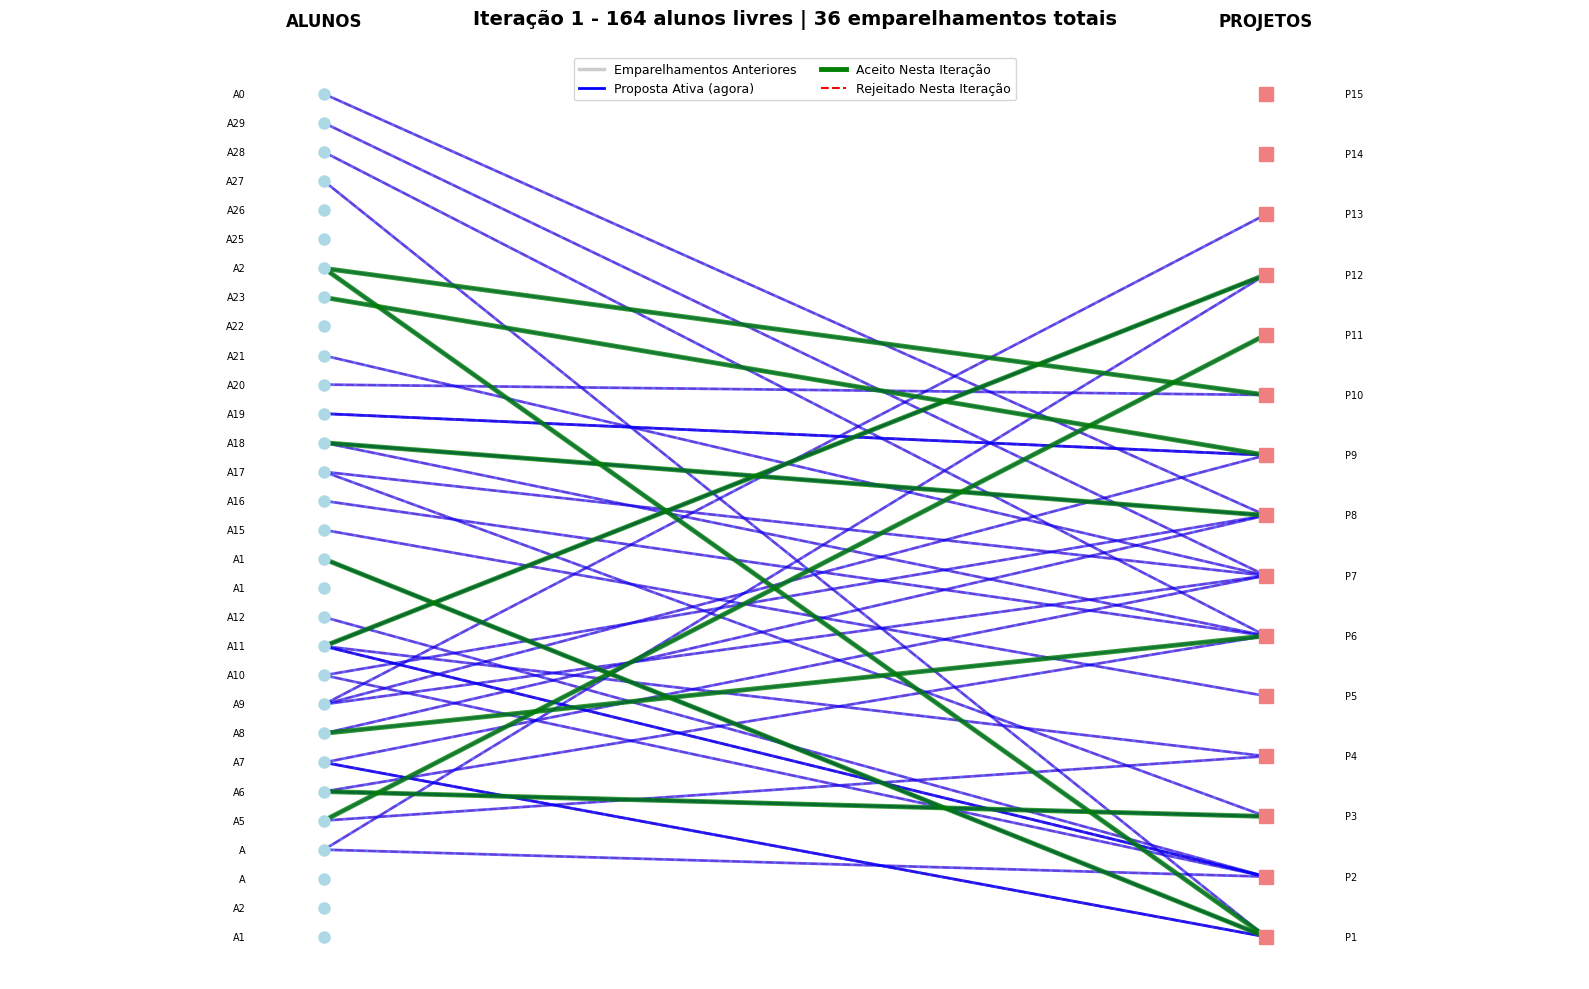


Visualizando iteração 2...


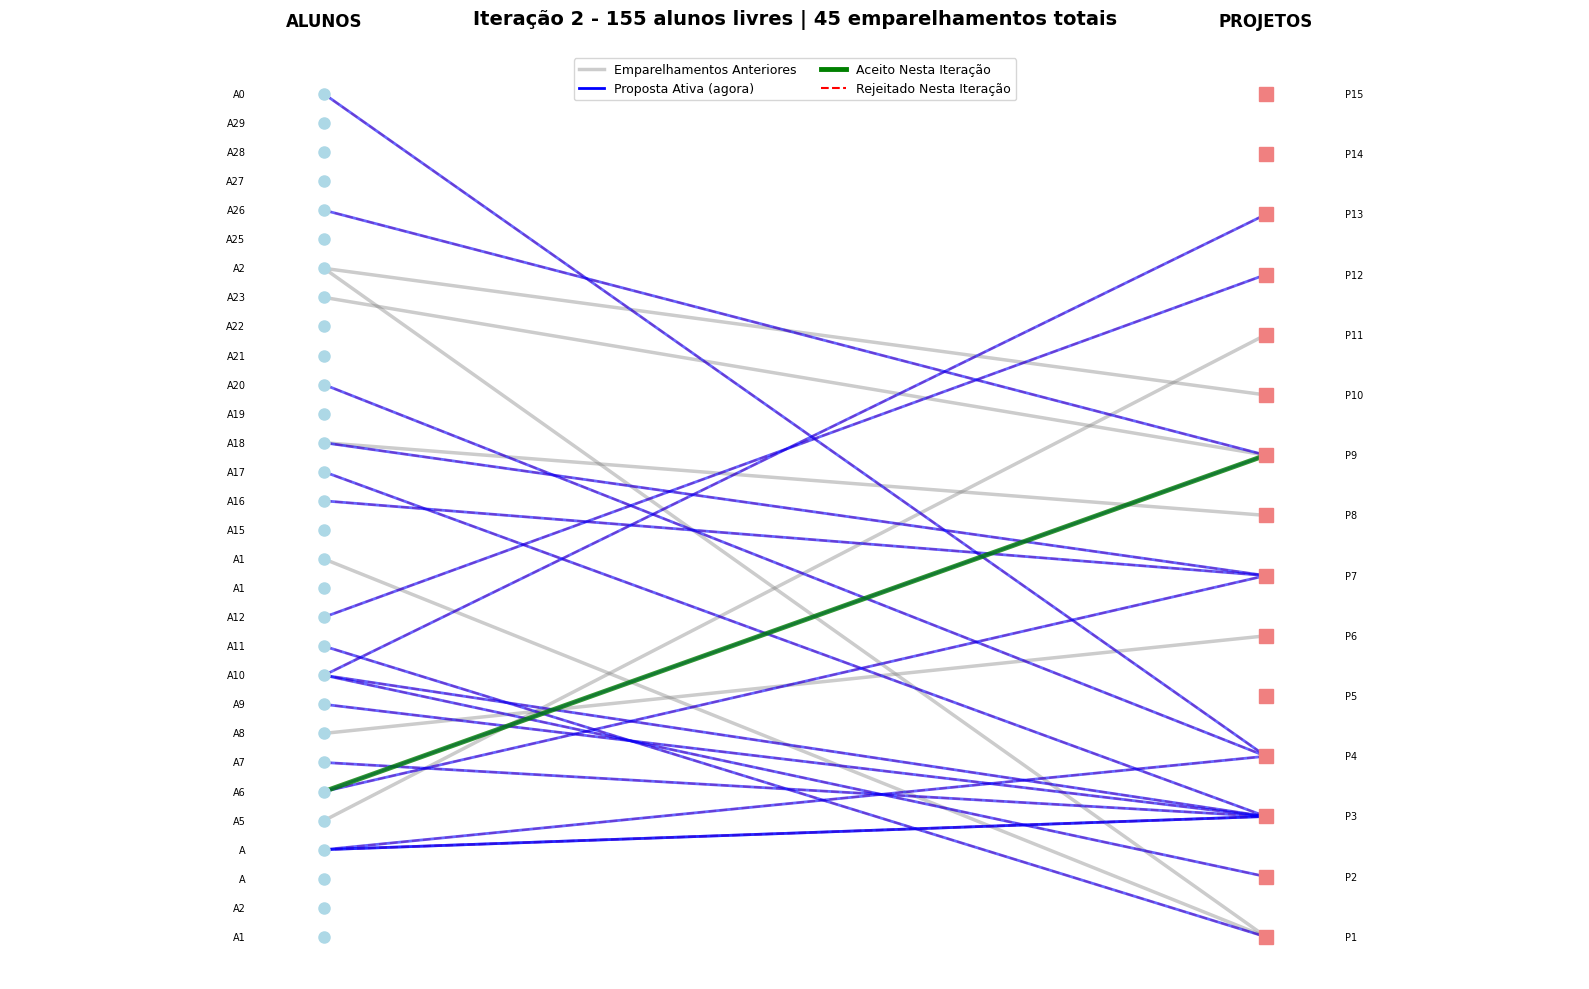


Visualizando iteração 3...


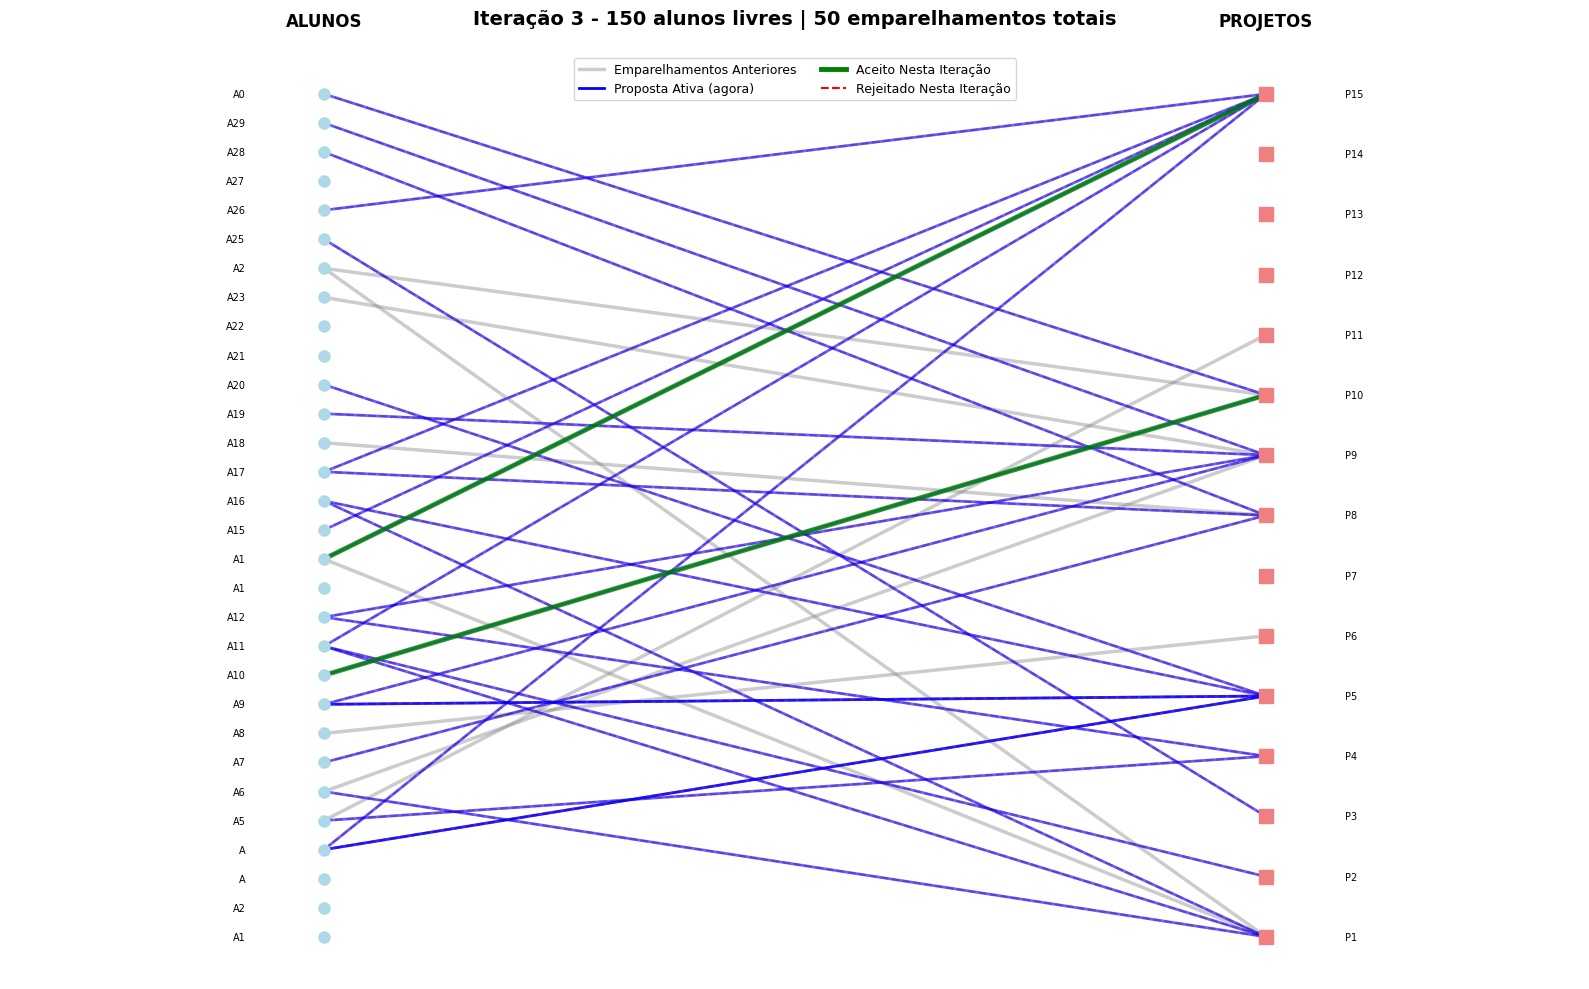


Visualizando iteração 4...


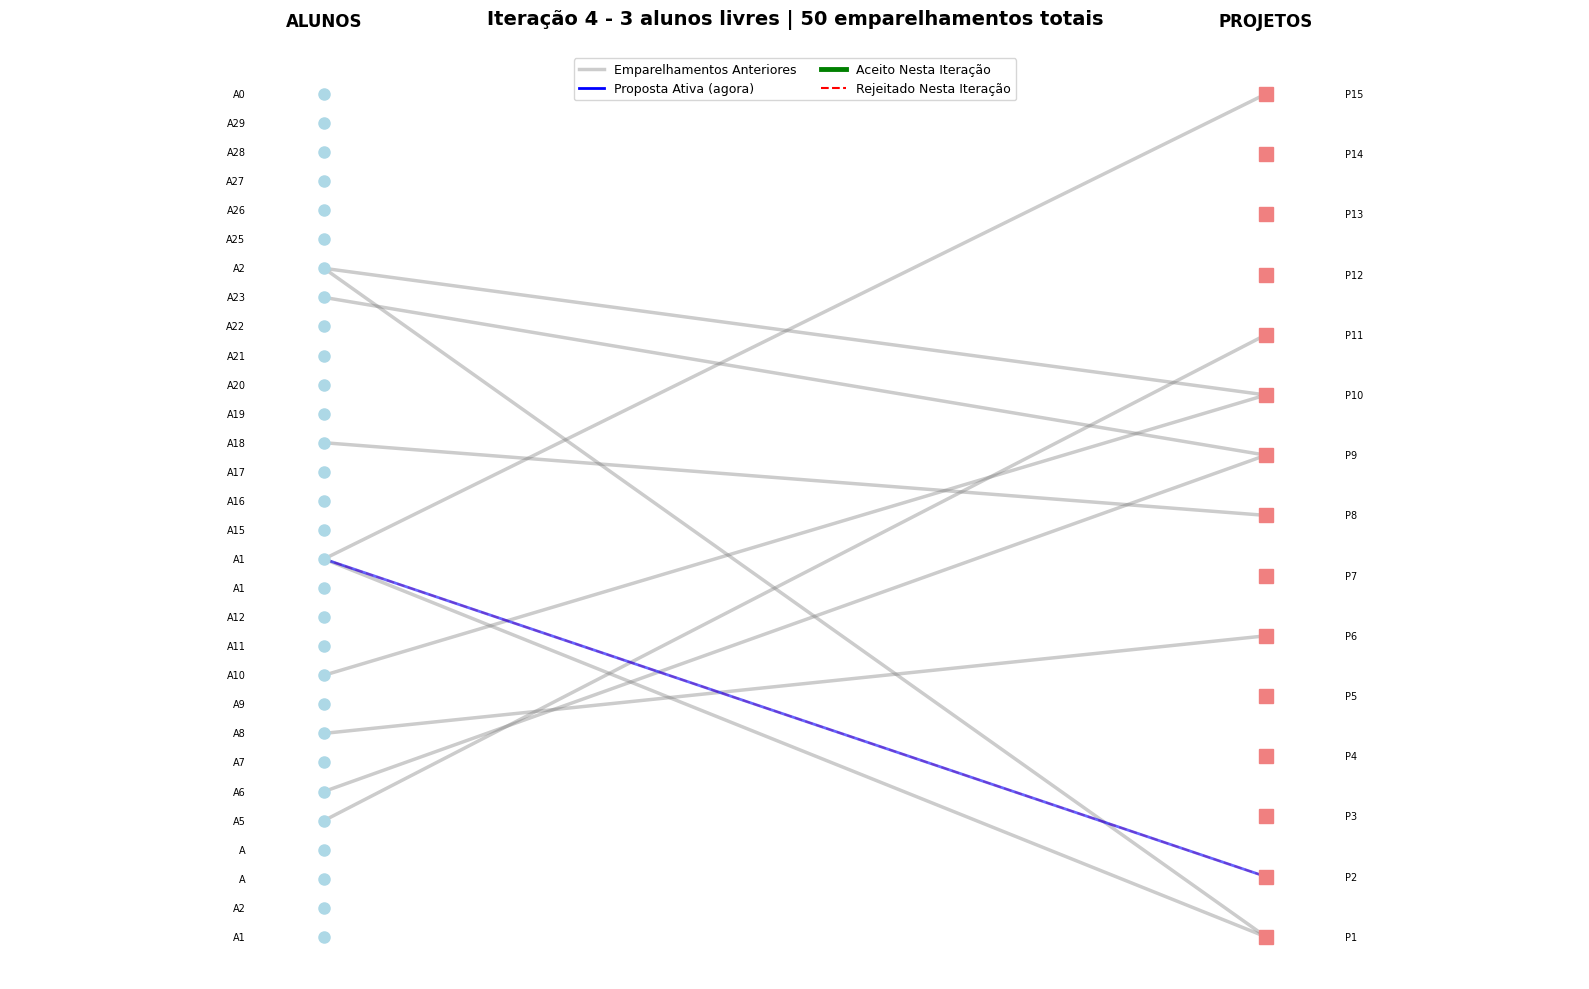


Visualizando iteração 5...


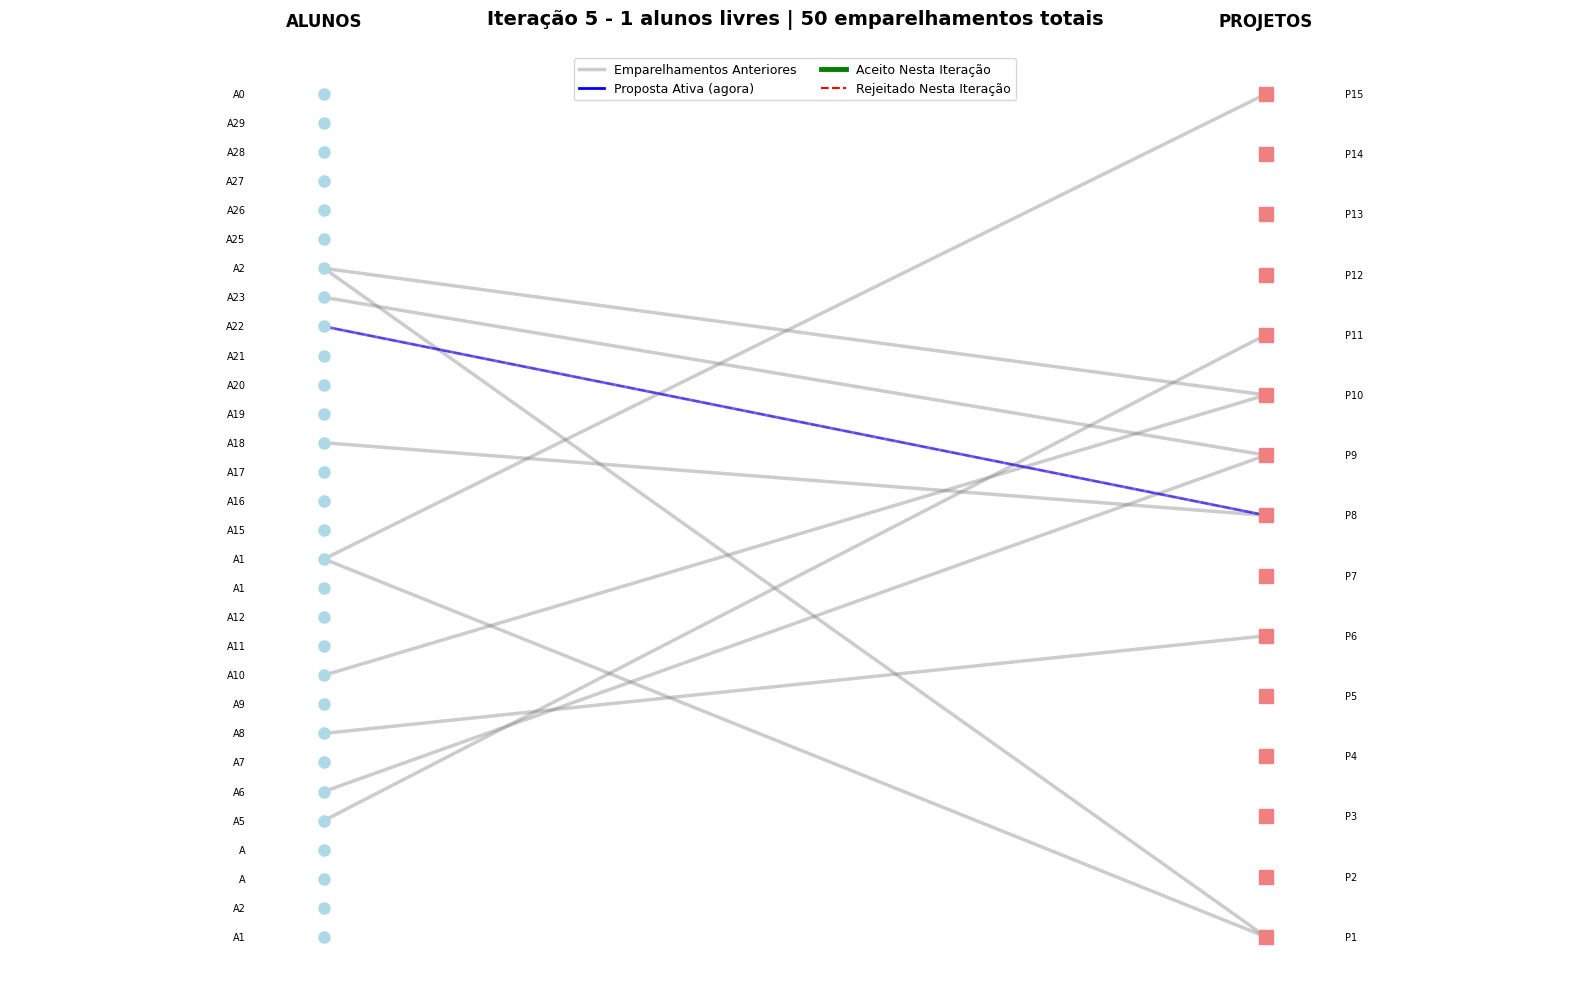


Visualizando iteração 6...


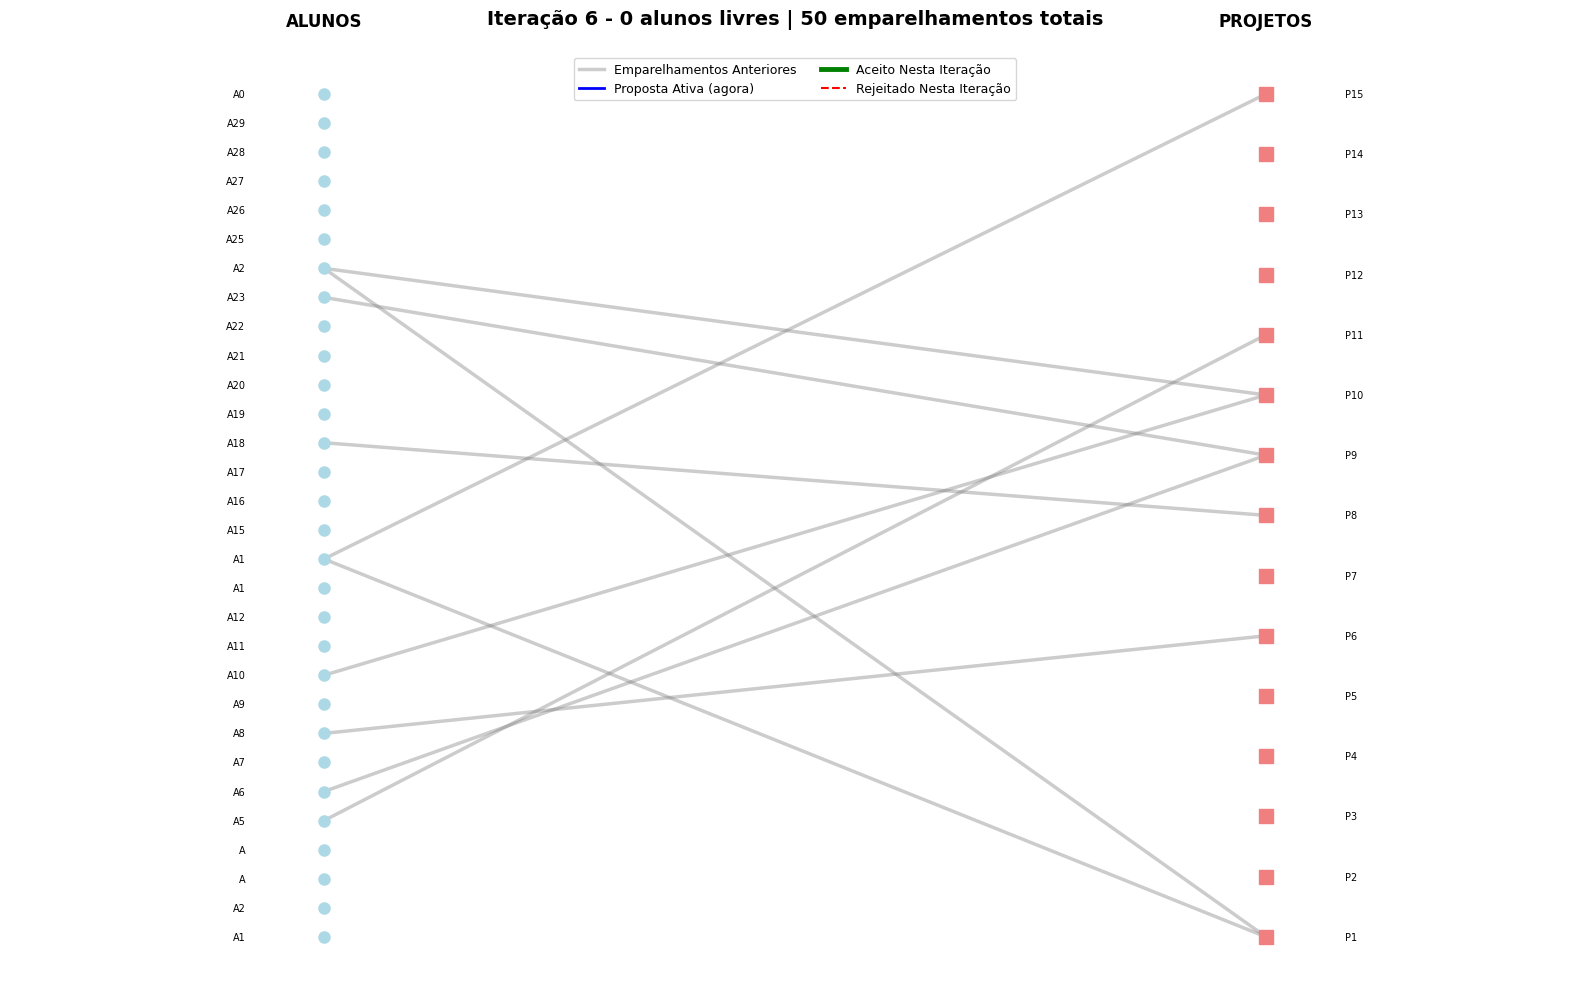

In [29]:
# Visualizar as 10 primeiras iterações
alunos_codes = [a.codigo for a in alunos]
projetos_codes = list(projetos.keys())

for i, iteracao_data in enumerate(historico[:10]):
    print(f"\nVisualizando iteração {iteracao_data['iteracao']}...")
    fig = visualizar_grafo_iteracao(iteracao_data, alunos_codes, projetos_codes)
    plt.show()

## 9. Matriz de Emparelhamento Final

In [30]:
# Construir matriz de emparelhamento final
dados_matriz = []

for aluno in alunos:
    if aluno.projeto_atual:
        # Encontrar rank do aluno na preferência (1, 2 ou 3)
        try:
            rank_aluno = aluno.preferencias.index(aluno.projeto_atual) + 1
        except ValueError:
            rank_aluno = 0  # Não estava nas preferências
        
        # Encontrar rank do projeto na lista de alunos aceitos
        projeto = projetos[aluno.projeto_atual]
        alunos_projeto_ordenados = sorted(projeto.alunos_aceitos, key=lambda a: a.nota, reverse=True)
        rank_projeto = alunos_projeto_ordenados.index(aluno) + 1
        
        dados_matriz.append({
            'Aluno': aluno.codigo,
            'Projeto_Emparelhado': aluno.projeto_atual,
            'Rank_Aluno': rank_aluno,  # Ordem de escolha do aluno (1=1ª opção)
            'Rank_Projeto': rank_projeto,  # Posição do aluno na lista do projeto
            'Nota_Aluno': aluno.nota,
            'Requisito_Projeto': projeto.requisito_minimo,
            'Vagas_Projeto': projeto.numero_vagas,
            'Alunos_Aceitos': len(projeto.alunos_aceitos)
        })

matriz_emparelhamento = pd.DataFrame(dados_matriz)

print("\nMATRIZ DE EMPARELHAMENTO FINAL (primeiras 20 linhas):")
print("="*100)
print(matriz_emparelhamento.head(20).to_string(index=False))

print(f"\n\nTotal de emparelhamentos: {len(matriz_emparelhamento)}")


MATRIZ DE EMPARELHAMENTO FINAL (primeiras 20 linhas):
Aluno Projeto_Emparelhado  Rank_Aluno  Rank_Projeto  Nota_Aluno  Requisito_Projeto  Vagas_Projeto  Alunos_Aceitos
   A1                  P1           1             1           5                  5              2               2
   A2                  P1           1             2           5                  5              2               2
   A6                  P9           2             2           4                  4              2               2
   A8                  P6           1             1           5                  5              2               1
  A10                 P10           3             3           4                  4              3               3
   A1                 P15           3             2           4                  4              2               2
  A18                  P8           1             1           5                  5              2               2
  A23                  P9        

In [31]:
# Salvar matriz em CSV
matriz_emparelhamento.to_csv('matriz_emparelhamento_final.csv', index=False, sep=';')
print("Matriz salva em 'matriz_emparelhamento_final.csv'")

Matriz salva em 'matriz_emparelhamento_final.csv'


## 10. Índice de Preferência por Projeto

In [32]:
# Calcular índice de preferência
indice_preferencia = []

for codigo_projeto, projeto in projetos.items():
    if len(projeto.alunos_aceitos) > 0:
        # Contar quantas vezes aparece como preferência
        total_primeira = sum(1 for a in alunos if len(a.preferencias) > 0 and a.preferencias[0] == codigo_projeto)
        total_segunda = sum(1 for a in alunos if len(a.preferencias) > 1 and a.preferencias[1] == codigo_projeto)
        total_terceira = sum(1 for a in alunos if len(a.preferencias) > 2 and a.preferencias[2] == codigo_projeto)
        
        # Índice ponderado: 1ª escolha = 3 pontos, 2ª = 2 pontos, 3ª = 1 ponto
        indice = (total_primeira * 3) + (total_segunda * 2) + (total_terceira * 1)
        
        # Média de notas dos alunos aceitos
        media_notas = np.mean([a.nota for a in projeto.alunos_aceitos])
        
        indice_preferencia.append({
            'Projeto': codigo_projeto,
            'Alunos_Aceitos': len(projeto.alunos_aceitos),
            'Vagas_Totais': projeto.numero_vagas,
            'Taxa_Ocupacao': len(projeto.alunos_aceitos) / projeto.numero_vagas * 100,
            'Primeira_Escolha': total_primeira,
            'Segunda_Escolha': total_segunda,
            'Terceira_Escolha': total_terceira,
            'Indice_Preferencia': indice,
            'Media_Notas': media_notas
        })

df_indice = pd.DataFrame(indice_preferencia)
df_indice = df_indice.sort_values('Indice_Preferencia', ascending=False)

print("\nÍNDICE DE PREFERÊNCIA POR PROJETO (Top 20):")
print("="*120)
print(df_indice.head(20).to_string(index=False))


ÍNDICE DE PREFERÊNCIA POR PROJETO (Top 20):
Projeto  Alunos_Aceitos  Vagas_Totais  Taxa_Ocupacao  Primeira_Escolha  Segunda_Escolha  Terceira_Escolha  Indice_Preferencia  Media_Notas
     P8               2             2          100.0                13                7                15                  68     5.000000
     P4               1             1          100.0                 8               13                 9                  59     5.000000
     P2               1             1          100.0                14                4                 8                  58     5.000000
     P7               2             2          100.0                13                8                 0                  55     5.000000
     P1               2             2          100.0                10                7                10                  54     5.000000
     P3               2             2          100.0                 7               14                 4                

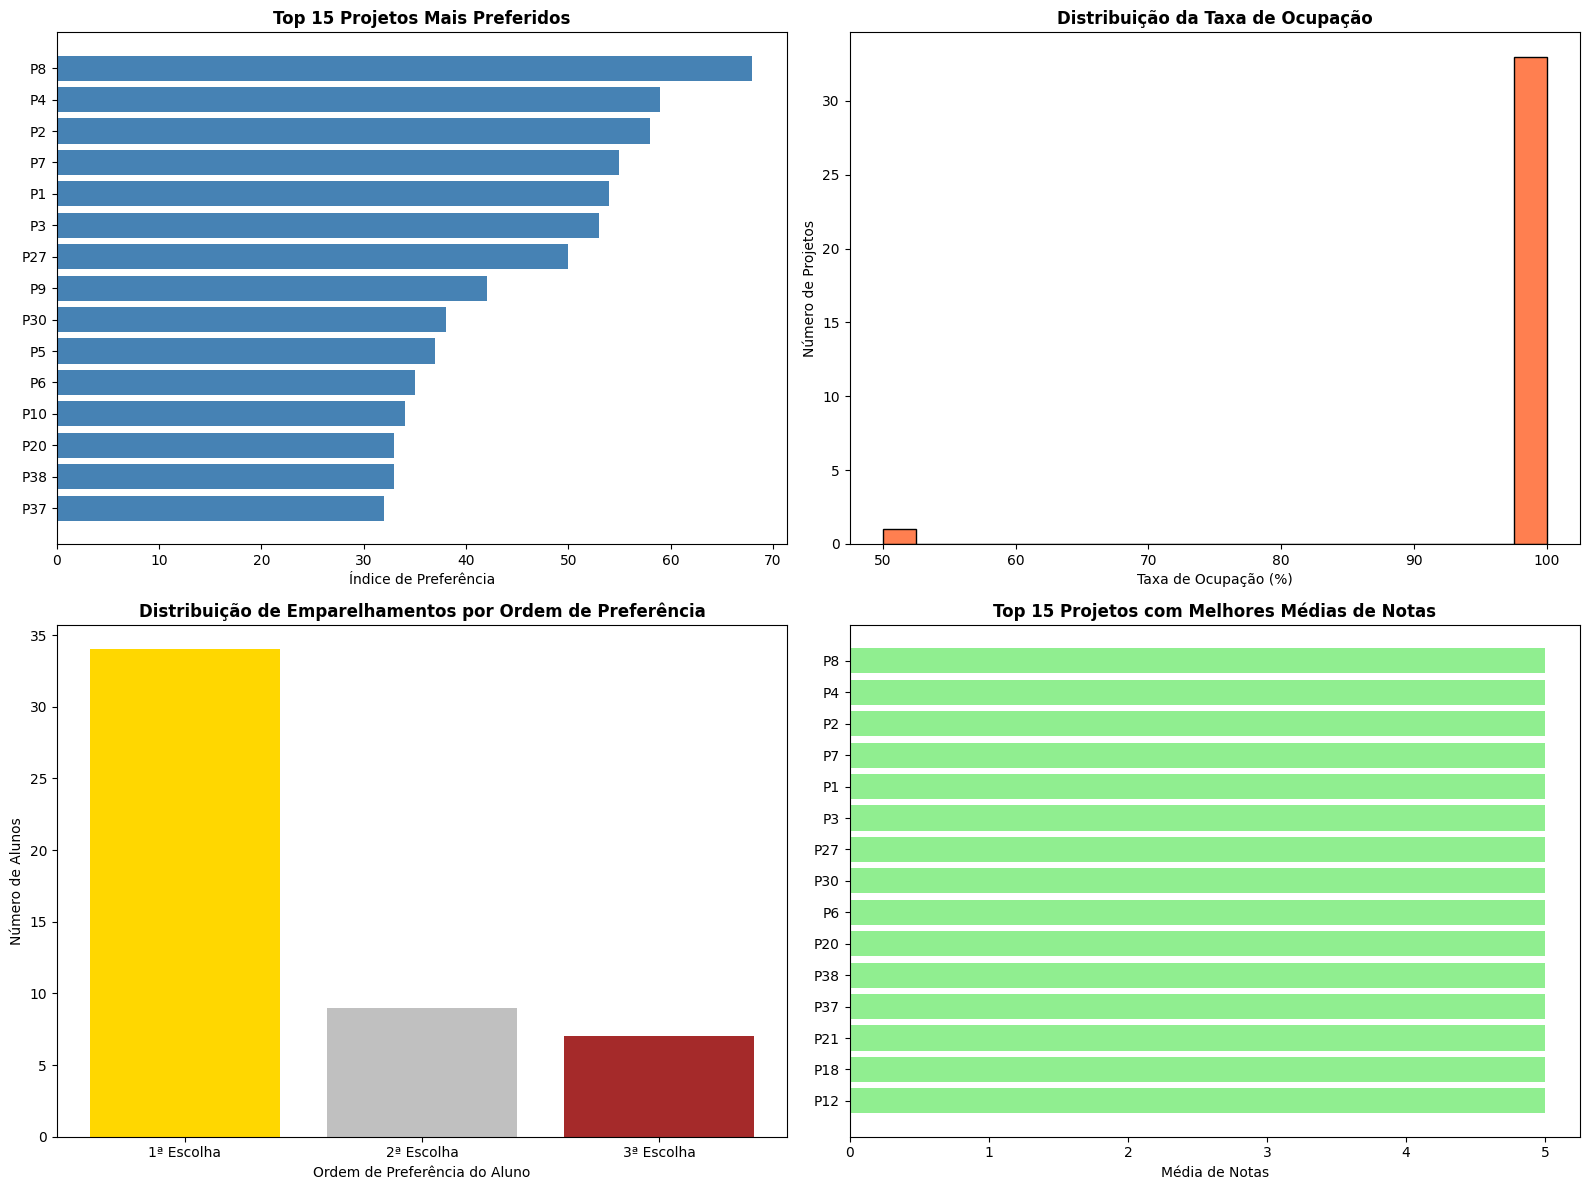

In [33]:
# Visualização do índice de preferência
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 15 projetos mais preferidos
top_15 = df_indice.head(15)
axes[0, 0].barh(top_15['Projeto'], top_15['Indice_Preferencia'], color='steelblue')
axes[0, 0].set_xlabel('Índice de Preferência', fontsize=10)
axes[0, 0].set_title('Top 15 Projetos Mais Preferidos', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()

# Taxa de ocupação
projetos_com_alunos_df = df_indice[df_indice['Alunos_Aceitos'] > 0]
axes[0, 1].hist(projetos_com_alunos_df['Taxa_Ocupacao'], bins=20, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Taxa de Ocupação (%)', fontsize=10)
axes[0, 1].set_ylabel('Número de Projetos', fontsize=10)
axes[0, 1].set_title('Distribuição da Taxa de Ocupação', fontsize=12, fontweight='bold')

# Distribuição de escolhas
if len(matriz_emparelhamento) > 0:
    escolhas_count = matriz_emparelhamento['Rank_Aluno'].value_counts().sort_index()
    axes[1, 0].bar(escolhas_count.index, escolhas_count.values, color=['gold', 'silver', 'brown'])
    axes[1, 0].set_xlabel('Ordem de Preferência do Aluno', fontsize=10)
    axes[1, 0].set_ylabel('Número de Alunos', fontsize=10)
    axes[1, 0].set_title('Distribuição de Emparelhamentos por Ordem de Preferência', fontsize=12, fontweight='bold')
    axes[1, 0].set_xticks([1, 2, 3])
    axes[1, 0].set_xticklabels(['1ª Escolha', '2ª Escolha', '3ª Escolha'])

# Média de notas por projeto
top_notas = df_indice.nlargest(15, 'Media_Notas')
axes[1, 1].barh(top_notas['Projeto'], top_notas['Media_Notas'], color='lightgreen')
axes[1, 1].set_xlabel('Média de Notas', fontsize=10)
axes[1, 1].set_title('Top 15 Projetos com Melhores Médias de Notas', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## 11. Visualização da Matriz Final de Emparelhamento

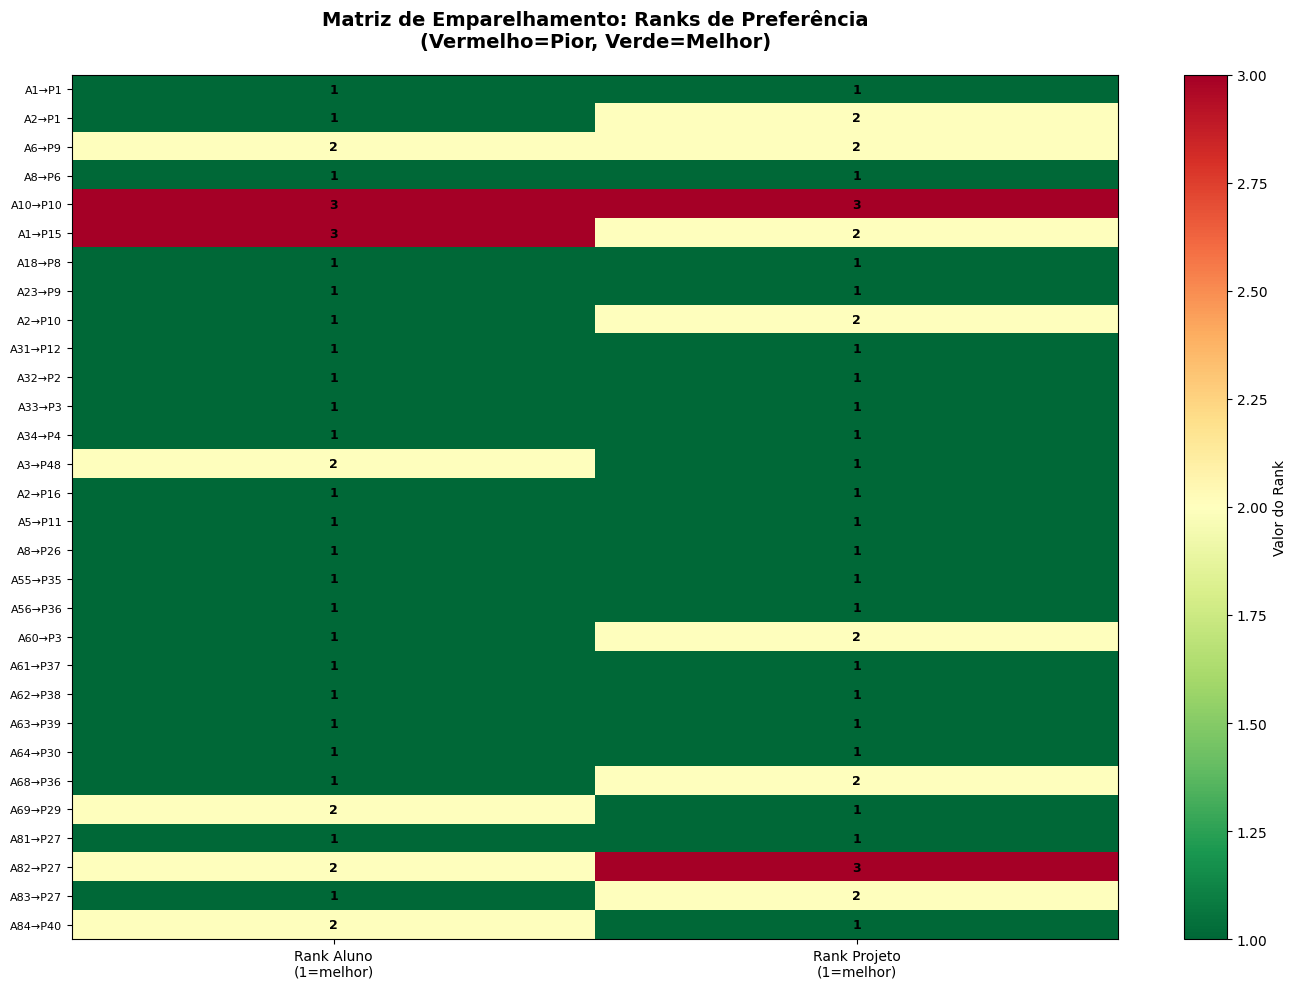

In [34]:
# Visualizar matriz como heatmap de ganho/perda
if len(matriz_emparelhamento) > 0:
    # Criar matriz de ganho (menor rank = melhor)
    # Ganho do aluno: 1ª escolha = +2, 2ª = 0, 3ª = -2
    # Ganho do projeto: Rank alto (aluno preferido) = +, Rank baixo = -
    
    matriz_vis = matriz_emparelhamento.copy()
    matriz_vis['Ganho_Aluno'] = matriz_vis['Rank_Aluno'].apply(lambda x: 3 - x if x > 0 else -3)
    
    # Amostra para visualização
    amostra = matriz_vis.head(30)
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Criar matriz de cores baseada no ganho
    dados_heatmap = []
    labels_y = []
    
    for idx, row in amostra.iterrows():
        dados_heatmap.append([row['Rank_Aluno'], row['Rank_Projeto']])
        labels_y.append(f"{row['Aluno']}→{row['Projeto_Emparelhado']}")
    
    im = ax.imshow(dados_heatmap, cmap='RdYlGn_r', aspect='auto')
    
    # Configurar eixos
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Rank Aluno\n(1=melhor)', 'Rank Projeto\n(1=melhor)'], fontsize=10)
    ax.set_yticks(range(len(labels_y)))
    ax.set_yticklabels(labels_y, fontsize=8)
    
    # Adicionar valores nas células
    for i in range(len(dados_heatmap)):
        for j in range(2):
            text = ax.text(j, i, int(dados_heatmap[i][j]),
                          ha="center", va="center", color="black", fontsize=9, fontweight='bold')
    
    ax.set_title('Matriz de Emparelhamento: Ranks de Preferência\n(Vermelho=Pior, Verde=Melhor)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.colorbar(im, ax=ax, label='Valor do Rank')
    plt.tight_layout()
    plt.show()

## 12. Análise de Ganho/Perda

In [35]:
# Análise de satisfação
if len(matriz_emparelhamento) > 0:
    print("\nANÁLISE DE SATISFAÇÃO DOS EMPARELHAMENTOS:")
    print("="*80)
    
    # Satisfação dos alunos
    primeira_escolha = len(matriz_emparelhamento[matriz_emparelhamento['Rank_Aluno'] == 1])
    segunda_escolha = len(matriz_emparelhamento[matriz_emparelhamento['Rank_Aluno'] == 2])
    terceira_escolha = len(matriz_emparelhamento[matriz_emparelhamento['Rank_Aluno'] == 3])
    
    total_emparelhados = len(matriz_emparelhamento)
    
    print(f"\nSatisfação dos Alunos Emparelhados:")
    print(f"  1ª Escolha: {primeira_escolha} ({primeira_escolha/total_emparelhados*100:.1f}%)")
    print(f"  2ª Escolha: {segunda_escolha} ({segunda_escolha/total_emparelhados*100:.1f}%)")
    print(f"  3ª Escolha: {terceira_escolha} ({terceira_escolha/total_emparelhados*100:.1f}%)")
    
    # Satisfação dos projetos
    print(f"\nSatisfação dos Projetos:")
    projetos_preenchidos = len([p for p in projetos.values() if len(p.alunos_aceitos) == p.numero_vagas])
    projetos_parciais = len([p for p in projetos.values() if 0 < len(p.alunos_aceitos) < p.numero_vagas])
    projetos_vazios = len([p for p in projetos.values() if len(p.alunos_aceitos) == 0])
    
    print(f"  Totalmente preenchidos: {projetos_preenchidos} ({projetos_preenchidos/len(projetos)*100:.1f}%)")
    print(f"  Parcialmente preenchidos: {projetos_parciais} ({projetos_parciais/len(projetos)*100:.1f}%)")
    print(f"  Vazios: {projetos_vazios} ({projetos_vazios/len(projetos)*100:.1f}%)")
    
    # Qualidade dos emparelhamentos
    media_rank_aluno = matriz_emparelhamento['Rank_Aluno'].mean()
    media_rank_projeto = matriz_emparelhamento['Rank_Projeto'].mean()
    
    print(f"\nQualidade Média:")
    print(f"  Rank médio do aluno: {media_rank_aluno:.2f} (1.0 = todos na 1ª escolha)")
    print(f"  Rank médio no projeto: {media_rank_projeto:.2f} (1.0 = todos são 1ª escolha do projeto)")


ANÁLISE DE SATISFAÇÃO DOS EMPARELHAMENTOS:

Satisfação dos Alunos Emparelhados:
  1ª Escolha: 34 (68.0%)
  2ª Escolha: 9 (18.0%)
  3ª Escolha: 7 (14.0%)

Satisfação dos Projetos:
  Totalmente preenchidos: 33 (66.0%)
  Parcialmente preenchidos: 1 (2.0%)
  Vazios: 16 (32.0%)

Qualidade Média:
  Rank médio do aluno: 1.46 (1.0 = todos na 1ª escolha)
  Rank médio no projeto: 1.36 (1.0 = todos são 1ª escolha do projeto)


## 13. Exportação de Todos os Resultados

In [36]:
# Salvar índice de preferência
df_indice.to_csv('indice_preferencia_projetos.csv', index=False, sep=';')

# Salvar lista de alunos não emparelhados
alunos_nao_emparelhados_data = []
for aluno in alunos_nao_emparelhados:
    alunos_nao_emparelhados_data.append({
        'Codigo_Aluno': aluno.codigo,
        'Nota': aluno.nota,
        'Preferencias': ', '.join(aluno.preferencias),
        'Tentativas': aluno.indice_proposta
    })

df_nao_emparelhados = pd.DataFrame(alunos_nao_emparelhados_data)
df_nao_emparelhados.to_csv('alunos_nao_emparelhados.csv', index=False, sep=';')

# Salvar estatísticas por projeto
estatisticas_projetos = []
for codigo, projeto in projetos.items():
    estatisticas_projetos.append({
        'Codigo_Projeto': codigo,
        'Vagas_Totais': projeto.numero_vagas,
        'Requisito_Minimo': projeto.requisito_minimo,
        'Alunos_Aceitos': len(projeto.alunos_aceitos),
        'Taxa_Ocupacao': len(projeto.alunos_aceitos) / projeto.numero_vagas * 100 if projeto.numero_vagas > 0 else 0,
        'Nota_Media': np.mean([a.nota for a in projeto.alunos_aceitos]) if projeto.alunos_aceitos else 0,
        'Nota_Min': min([a.nota for a in projeto.alunos_aceitos]) if projeto.alunos_aceitos else 0,
        'Nota_Max': max([a.nota for a in projeto.alunos_aceitos]) if projeto.alunos_aceitos else 0
    })

df_estatisticas = pd.DataFrame(estatisticas_projetos)
df_estatisticas.to_csv('estatisticas_projetos.csv', index=False, sep=';')

print("\nArquivos exportados:")
print("  - matriz_emparelhamento_final.csv")
print("  - indice_preferencia_projetos.csv")
print("  - alunos_nao_emparelhados.csv")
print("  - estatisticas_projetos.csv")


Arquivos exportados:
  - matriz_emparelhamento_final.csv
  - indice_preferencia_projetos.csv
  - alunos_nao_emparelhados.csv
  - estatisticas_projetos.csv


## 14. Conclusões

O algoritmo de emparelhamento estável implementado baseou-se na variação SPA-student do algoritmo Gale-Shapley, adaptado para o contexto de alocação de alunos a projetos.

### Características da Implementação:

1. **Orientação por Alunos**: Os alunos propõem aos projetos em ordem de preferência
2. **Requisitos de Qualificação**: Projetos só aceitam alunos que atendem ao requisito mínimo de nota
3. **Capacidade Limitada**: Cada projeto tem um número máximo de vagas
4. **Estabilidade**: O algoritmo garante que não existam pares aluno-projeto bloqueadores
5. **Maximização**: Busca maximizar o número de emparelhamentos respeitando as restrições

### Visualizações Geradas:

- Grafos bipartidos coloridos mostrando a evolução das 10 primeiras iterações
- Matriz de emparelhamento final com ranks de ambos os lados
- Análise de índice de preferência por projeto
- Distribuições de satisfação e ocupação

### Referências:

Abraham, D.J., Irving, R.W., & Manlove, D.F. (2007). Two algorithms for the student-project allocation problem. Journal of Discrete Algorithms, 5(1), 73-90.